In [1]:
import tqdm
import math
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

Text(0, 0.5, 'y-label')

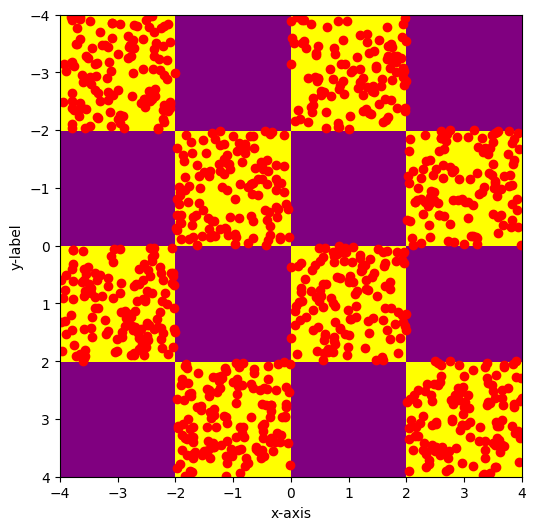

In [2]:
N = 1000
x_min,y_min = -4,4
x_max,y_max = 4,-4
resolution = 100

x = np.linspace(x_min,x_max,resolution)
y = np.linspace(y_min,y_max,resolution)

length = 4
checkerboard = np.indices((length,length)).sum(axis=0) % 2

sampled_points = []
while len(sampled_points) < N:
    x_sample = np.random.uniform(x_min,x_max)
    y_sample = np.random.uniform(y_min,y_max)
    i = int((x_sample - x_min) / (x_max - x_min) * length)
    j = int((y_sample - y_min) / (y_max - y_min) * length)
    if checkerboard[j,i] == 1:
        sampled_points.append((x_sample,y_sample))
    
sampled_points = np.array(sampled_points)
plt.figure(figsize=(6,6))
plt.imshow(checkerboard,extent=(x_min,x_max,y_min,y_max),origin='lower',cmap=ListedColormap(['purple','yellow']))
plt.scatter(sampled_points[:,0],sampled_points[:,1],color='red',marker="o")
plt.xlabel('x-axis')
plt.ylabel('y-label')

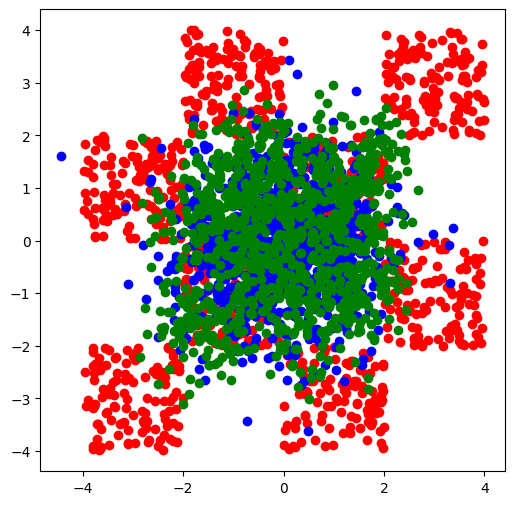

In [3]:
t = 0.5
noise = np.random.randn(N,2)
plt.figure(figsize=(6,6))
plt.scatter(sampled_points[:,0],sampled_points[:,1],color='red',marker='o')
plt.scatter(noise[:,0],noise[:,1],color='blue',marker='o')
plt.scatter((1-t)*noise[:,0] + t*sampled_points[:,0], (1-t)*noise[:,1] + t*sampled_points[:,1],color='green',marker='o')
plt.show()

In [7]:
class Block(nn.Module):
    def __init__(self,channels=512):
        super().__init__()
        self.ff = nn.Linear(channels,channels)
        self.act = nn.ReLU()
    def forward(self,x):
        return self.act(self.ff(x))
    
class MLP(nn.Module):
    def __init__(self,channels_data=2,layers=5,channels=512,channels_t=512):
        super().__init__()
        self.channels_t = channels_t
        self.in_projection = nn.Linear(channels_data,channels)
        self.t_projection = nn.Linear(channels_t,channels)
        self.blocks = nn.Sequential(*[
            Block(channels) for _ in range(layers)
        ])
        self.out_projection = nn.Linear(channels, channels_data)

    def gen_t_embedding(self,t,max_positions=10000):
        t = t*max_positions
        half_dim = self.channels_t // 2
        emb = math.log(max_positions) / (half_dim - 1)
        emb = torch.arange(half_dim,device=t.device).float().mul(-emb).exp()
        emb = t[:,None] * emb[None,:]
        emb = torch.cat([emb.sin(),emb.cos()], dim=1)
        if self.channels_t % 2 == 1:
            emb = nn.functional.pad(emb,(0,1),mode='constant')
        return emb
    
    def forward(self,x,t):
        x = self.in_projection(x)
        t = self.gen_t_embedding(t)
        t = self.t_projection(t)
        x = x + t
        x = self.blocks(x)
        x = self.out_projection(x)
        return x

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MLP(layers=5,channels=512).to(device)
optim = torch.optim.AdamW(model.parameters(),lr=1e-4)
print(device)

cuda


In [16]:
data = torch.Tensor(sampled_points).to(device)
training_steps = 100_000
batch_size = 64
pbar = tqdm.tqdm(range(training_steps))
losses = []
for i in pbar:
    x1 = data[torch.randint(data.size(0),(batch_size,))]
    x0 = torch.randn_like(x1).to(device)
    target = x1 - x0
    t = torch.rand(x1.size(0)).to(device)
    xt = (1 - t[:,None]) * x0 + t[:,None] * x1
    pred = model(xt,t)
    loss = ((target - pred)**2).mean()
    loss.backward()
    optim.step()
    optim.zero_grad()
    pbar.set_postfix(loss=loss.item())
    losses.append(loss.item())

100%|██████████| 100000/100000 [04:24<00:00, 377.58it/s, loss=3.14]


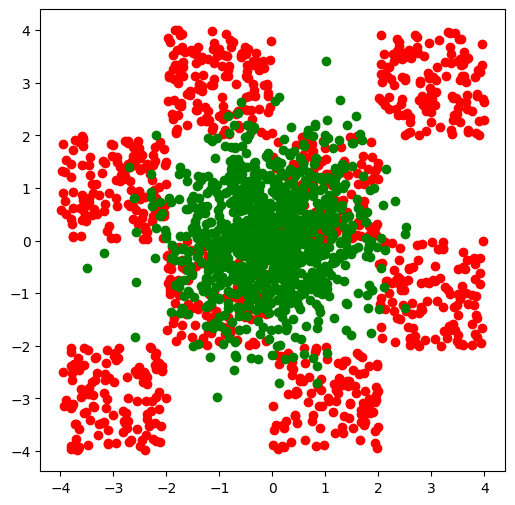

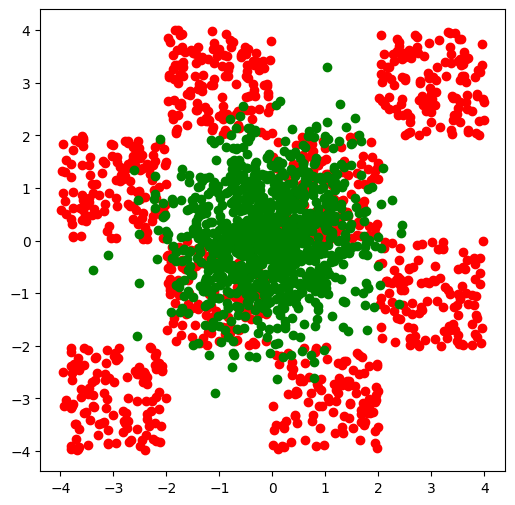

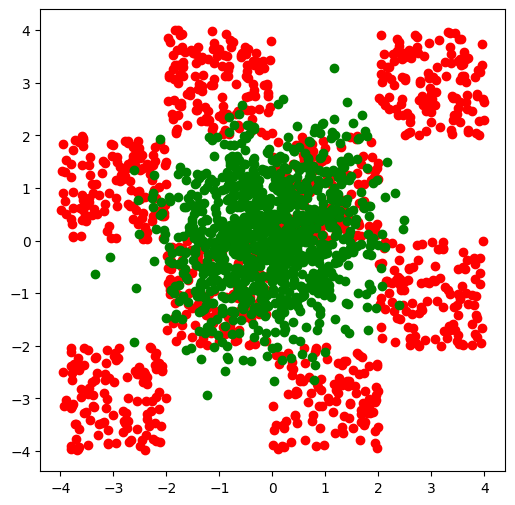

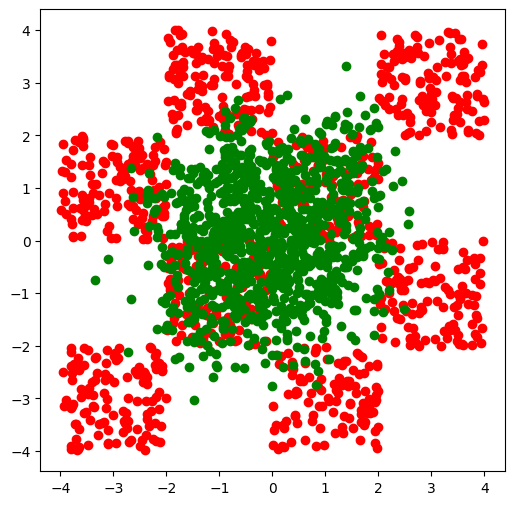

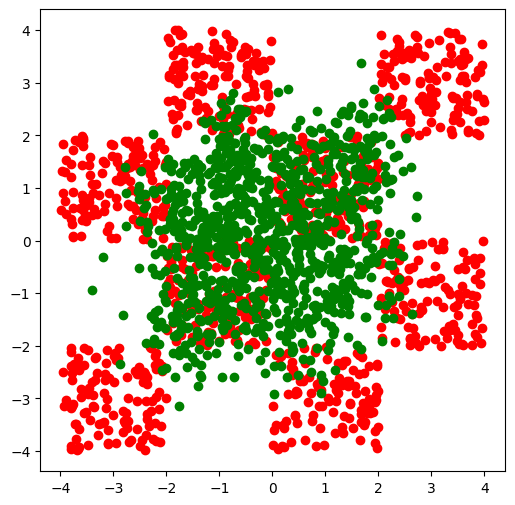

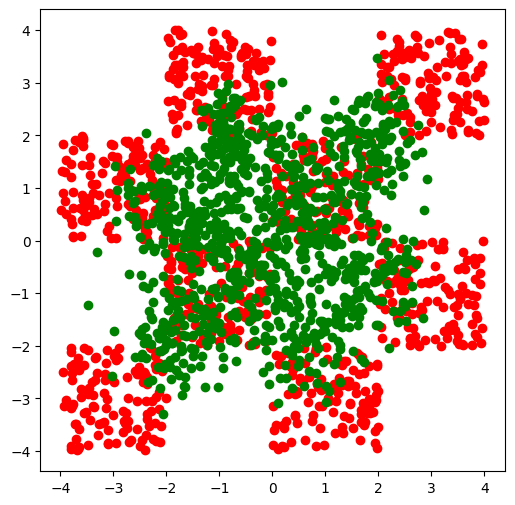

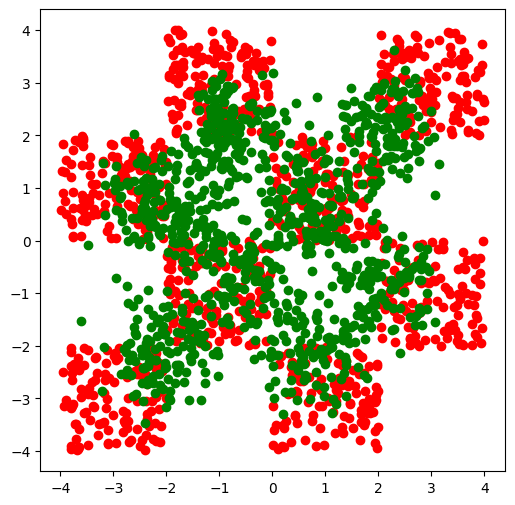

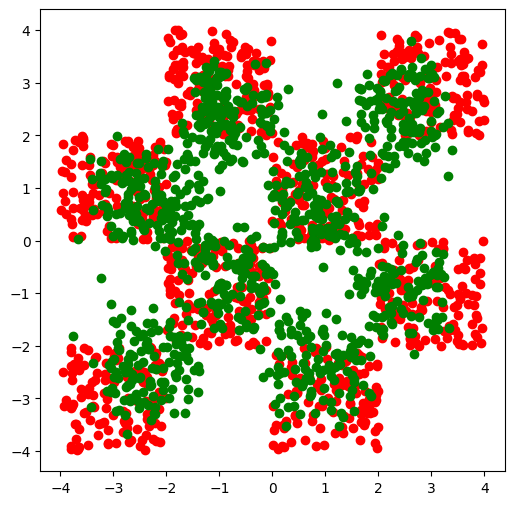

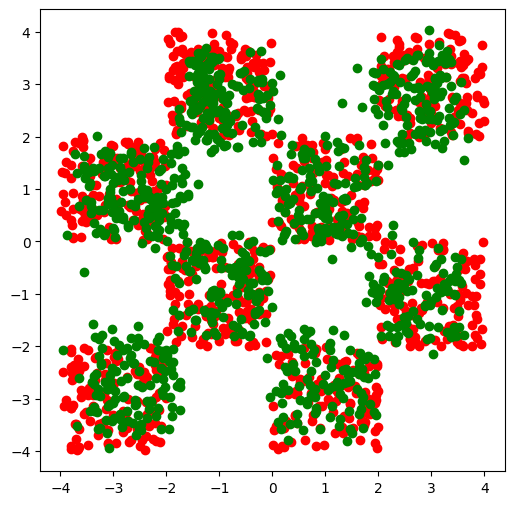

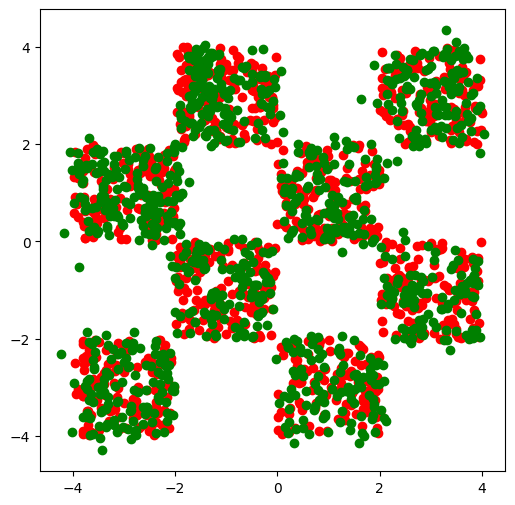

MLP(
  (in_projection): Linear(in_features=2, out_features=512, bias=True)
  (t_projection): Linear(in_features=512, out_features=512, bias=True)
  (blocks): Sequential(
    (0): Block(
      (ff): Linear(in_features=512, out_features=512, bias=True)
      (act): ReLU()
    )
    (1): Block(
      (ff): Linear(in_features=512, out_features=512, bias=True)
      (act): ReLU()
    )
    (2): Block(
      (ff): Linear(in_features=512, out_features=512, bias=True)
      (act): ReLU()
    )
    (3): Block(
      (ff): Linear(in_features=512, out_features=512, bias=True)
      (act): ReLU()
    )
    (4): Block(
      (ff): Linear(in_features=512, out_features=512, bias=True)
      (act): ReLU()
    )
  )
  (out_projection): Linear(in_features=512, out_features=2, bias=True)
)

In [20]:
model.eval().requires_grad_(False)
xt = torch.randn(1000,2).to(device)
steps = 1000
plot_every = 100
for i,t in enumerate(torch.linspace(0,1,steps), start=1):
    pred = model(xt,t.expand(xt.size(0)).to(device))
    xt = xt + (1/steps) * pred
    if i % plot_every == 0:
        plt.figure(figsize=(6,6))
        plt.scatter(sampled_points[:,0],sampled_points[:,1],color='red',marker='o')
        plt.scatter(xt[:,0].cpu(),xt[:,1].cpu(),color='green',marker='o')
        plt.show()
model.train().requires_grad_(True)